In [1]:
import pandas as pd

In [14]:
df = pd.read_csv('train.csv')

In [15]:
df['date'] = pd.to_datetime(df['date'])

df.dtypes

date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

In [25]:
import matplotlib.pyplot as plt

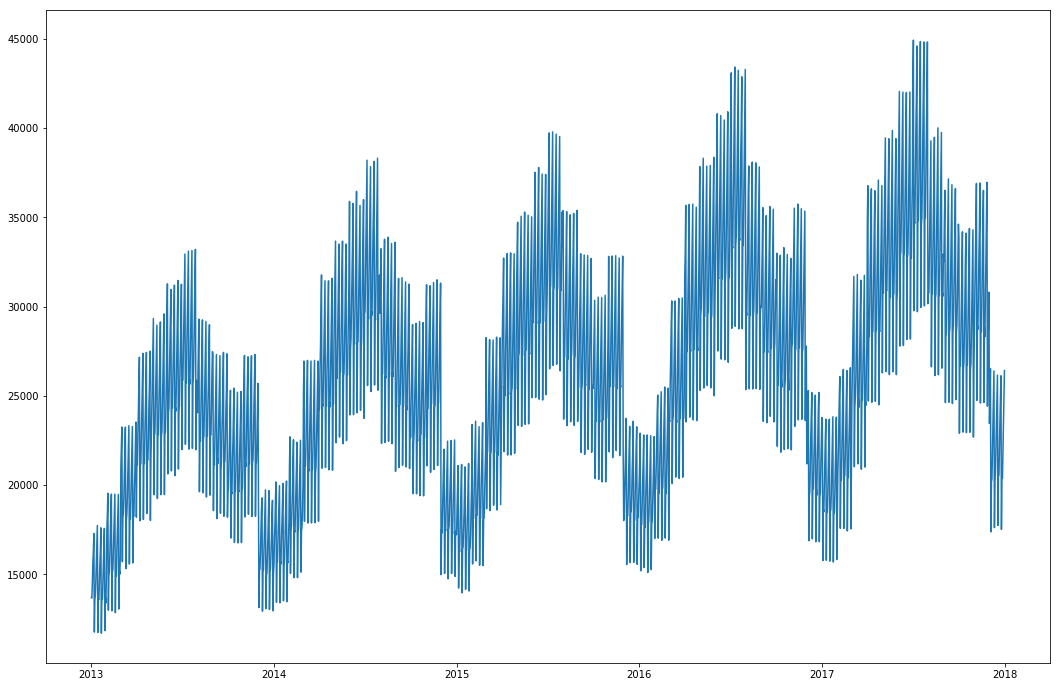

In [27]:
plt.figure(figsize=(18,12))
plt.plot(df_grouped['sales'])

In [28]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

<Figure size 1152x864 with 0 Axes>

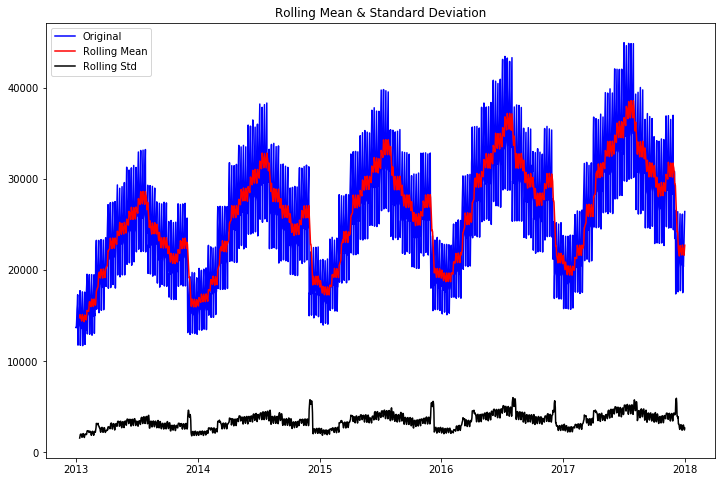

Results of Dickey-Fuller Test:
p-value = 0.0882. The series is likely non-stationary.
Test Statistic                   -2.623664
p-value                           0.088204
#Lags Used                       20.000000
Number of Observations Used    1805.000000
Critical Value (1%)              -3.433978
Critical Value (5%)              -2.863143
Critical Value (10%)             -2.567623
dtype: float64


In [29]:
plt.figure(figsize=(16,12))
test_stationarity(df_grouped['sales'])

In [30]:
import numpy as np

In [31]:
df_grouped['sales'] = np.log(df_grouped['sales'])

<Figure size 1152x864 with 0 Axes>

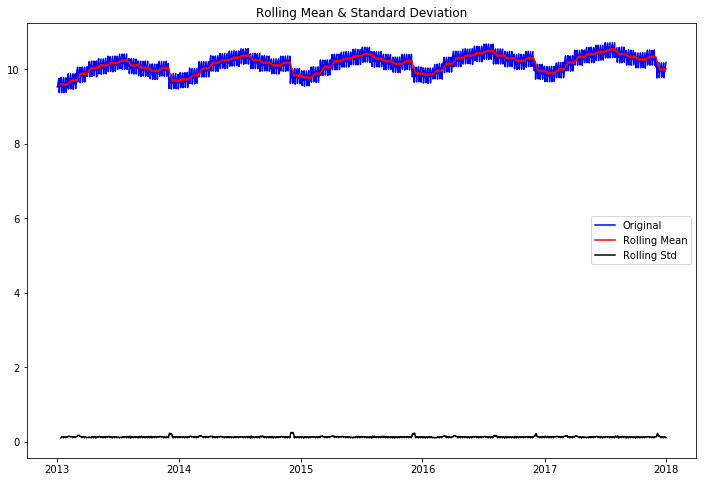

Results of Dickey-Fuller Test:
p-value = 0.0485. The series is likely non-stationary.
Test Statistic                   -2.873408
p-value                           0.048529
#Lags Used                       20.000000
Number of Observations Used    1805.000000
Critical Value (1%)              -3.433978
Critical Value (5%)              -2.863143
Critical Value (10%)             -2.567623
dtype: float64


In [32]:
plt.figure(figsize=(16,12))
test_stationarity(df_grouped['sales'])

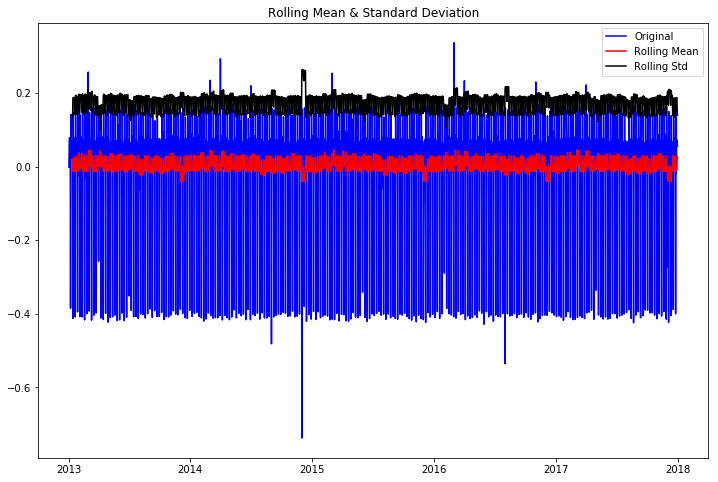

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -8.290851e+00
p-value                        4.265801e-13
#Lags Used                     2.000000e+01
Number of Observations Used    1.804000e+03
Critical Value (1%)           -3.433980e+00
Critical Value (5%)           -2.863143e+00
Critical Value (10%)          -2.567624e+00
dtype: float64


In [33]:
first_diff = df_grouped.sales - df_grouped.sales.shift(1)
first_diff.dropna(inplace = True)
test_stationarity(first_diff, window = 12)

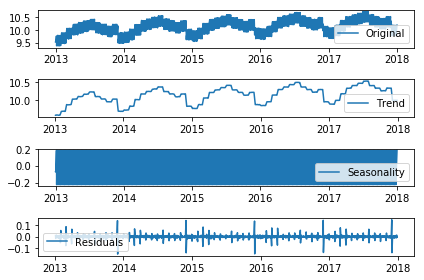

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_grouped['sales'])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df_grouped['sales'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

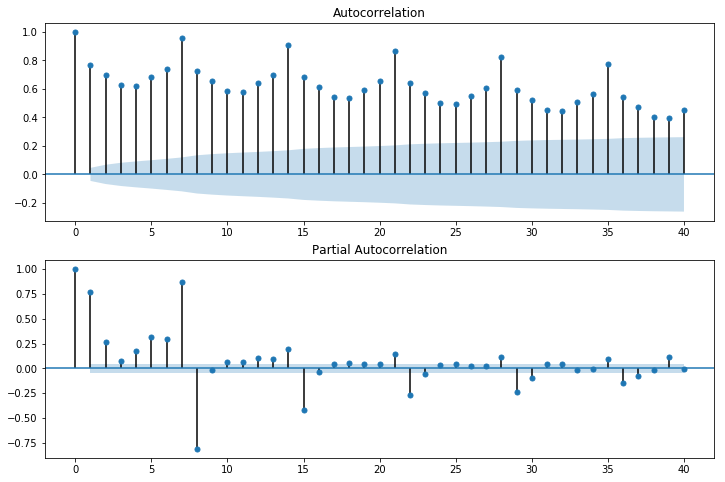

In [41]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_grouped.sales, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_grouped.sales, lags=40, ax=ax2)# , lags=40

C:\Users\sn3fru\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\sn3fru\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


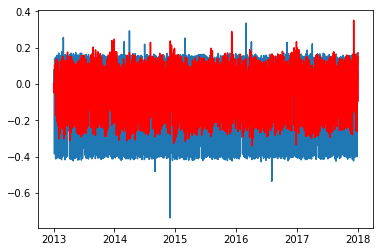

In [50]:
from statsmodels.tsa.arima_model import ARIMA

# MODELO AR
model = ARIMA(df_grouped['sales'], order=(3, 1, 6))  
results_AR = model.fit(disp=-1)
plt.plot(first_diff)
plt.plot(results_AR.fittedvalues, color='red')

In [71]:
### Sazonalidade
import statsmodels.api as sm
mod = sm.tsa.statespace.SARIMAX(df_grouped['sales'],
                                order=(0, 1, 6),
                                seasonal_order=(0,1,1,7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

print(results.summary().tables[1])

C:\Users\sn3fru\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0555      0.034     -1.656      0.098      -0.121       0.010
ma.L2         -0.0066      0.050     -0.132      0.895      -0.104       0.091
ma.L3          0.0012      0.048      0.025      0.980      -0.094       0.096
ma.L4          0.0042      0.064      0.065      0.948      -0.121       0.129
ma.L5          0.0082      0.058      0.140      0.888      -0.106       0.123
ma.L6         -0.0079      0.048     -0.167      0.868      -0.101       0.085
ma.S.L7       -0.9924      0.008   -123.682      0.000      -1.008      -0.977
sigma2         0.0007   4.16e-06    172.031      0.000       0.001       0.001


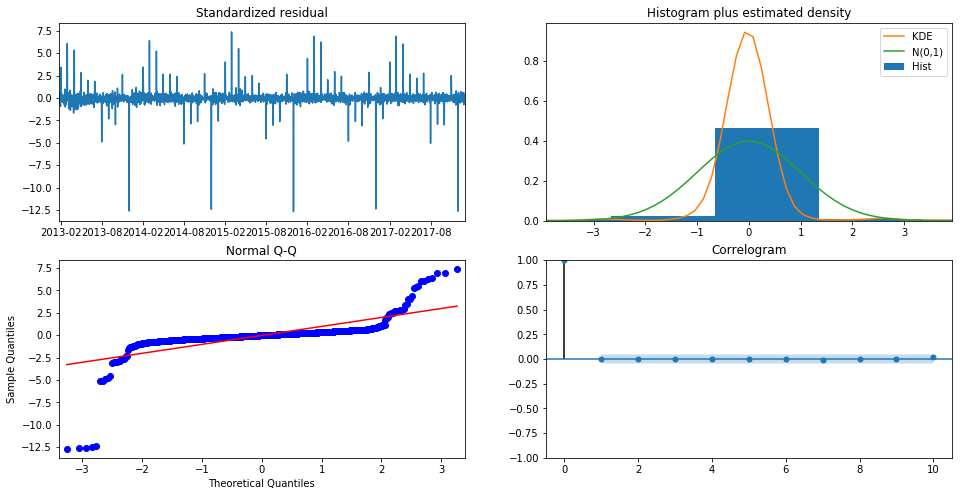

In [72]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [73]:
def smape_kun(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

In [74]:
start_index = '2017-10-01'
end_index = '2017-12-30'
end_index1 = '2017-12-31'

In [89]:
for p in range(1,2):
    for q in range(1,2):
        model = ARIMA(df_grouped['sales'], order=(p, 1, q))  
        results_AR = model.fit(disp=-1)
        print(p, q)
        
        # FALTA CONSTRUIR
        
        smape_kun(df_grouped[start_index:end_index]['sales'],df_grouped[start_index:end_index]['forecast'])

1 1


TypeError: cannot do slice indexing on <class 'pandas.core.indexes.range.RangeIndex'> with these indexers [2017-10-01] of <class 'str'>

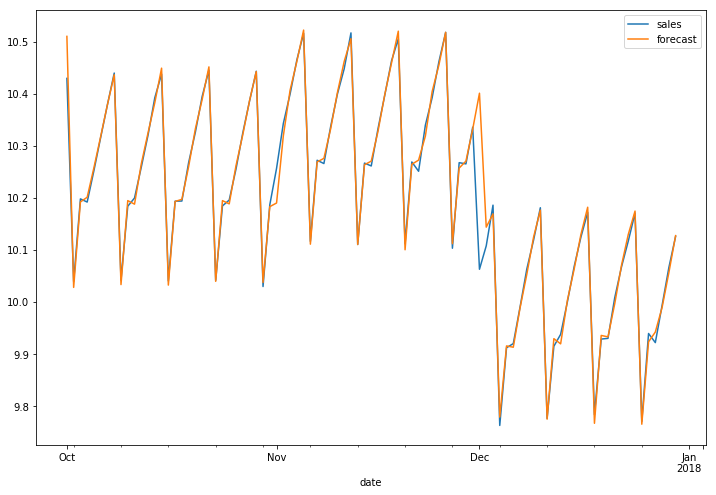

In [82]:
pred = results.get_prediction(start=pd.to_datetime(start_index), dynamic=False)
pred_ci = pred.conf_int()
pred_ci.mean(axis=1)
df_grouped['forecast'] = pred_ci.mean(axis=1)
df_grouped[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

In [83]:
smape_kun(df_grouped[start_index:end_index]['sales'],df_grouped[start_index:end_index]['forecast'])

MAPE: 0.13 % 
SMAPE: 0.13 %


# fbprophet

In [86]:
df_grouped.reset_index(inplace=True)

In [87]:
df_grouped.head()

,date,store,item,sales,forecast
0,2013-01-01,2750,12750,9.524859,NaN
1,2013-01-02,2750,12750,9.523544,NaN
2,2013-01-03,2750,12750,9.581076,NaN
3,2013-01-04,2750,12750,9.659950,NaN
4,2013-01-05,2750,12750,9.695048,NaN


INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

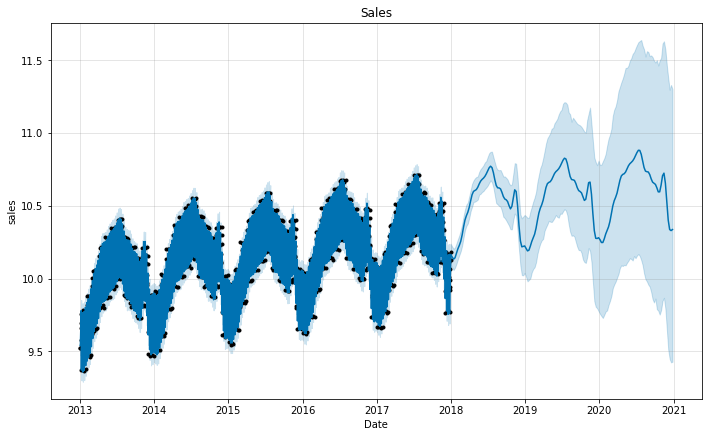

In [93]:
from fbprophet import Prophet

df_grouped = df_grouped.rename(columns={'date': 'ds', 'sales': 'y'})
df_grouped_model = Prophet(interval_width=0.95)
df_grouped_model.fit(df_grouped)


df_grouped_forecast = df_grouped_model.make_future_dataframe(periods=156,freq='w')
df_grouped_forecast = df_grouped_model.predict(df_grouped_forecast)


plt.figure(figsize=(18, 6))
df_grouped_model.plot(df_grouped_forecast, xlabel = 'Date', ylabel = 'sales')
plt.title('Sales');